# Compare SSH from ROMS output and reanalysis


Compare: 
- roms area averaged sea level height above geoid
- sea level height above geoid along Dutch coast

Data:
- GLORYS12V2 downloaded from https://resources.marine.copernicus.eu/product-detail/GLOBAL_MULTIYEAR_PHY_001_030/INFORMATION
- GLORYS2V3 downloaded from Dewi workstation: /net/pc200008/nobackup/users/bars/GLORYS2V3
- ROMS output Tim downloaded from http://doi.org/10.4121/uuid:d9656541-ff40-45d0-8859-ac644b155dfb
- altimetry downloaded from https://resources.marine.copernicus.eu/product-detail/SEALEVEL_EUR_PHY_L4_MY_008_068/INFORMATION
For Tim's run with 1/8° resolution and  + GLORYS12v1

Dewi's runs with 1/4° and 1/8° resolution + GLORYS2V3

ROMS domain: 36°N to 62°N and -20°W to 10°E

In [67]:
# Import necessary packages

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import linregress


f_cm = 100  # Conversion factor m->cm
f_mm = 1000  # Conversion factor m->mm

## SSH averaged over the ROMS domain

In [68]:
# Import GLORYS12V1 reanalysis data
glorys12v1 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/Glorys12v1/SSH/glorys12v1_annual.nc')


# Make extent of the Glorys12v1 data similar to ROMS
glorys12v1 = glorys12v1.where((glorys12v1.latitude > 36) & (glorys12v1.latitude < 62) & (glorys12v1.longitude > -20) & (glorys12v1.longitude < 10), drop = True)



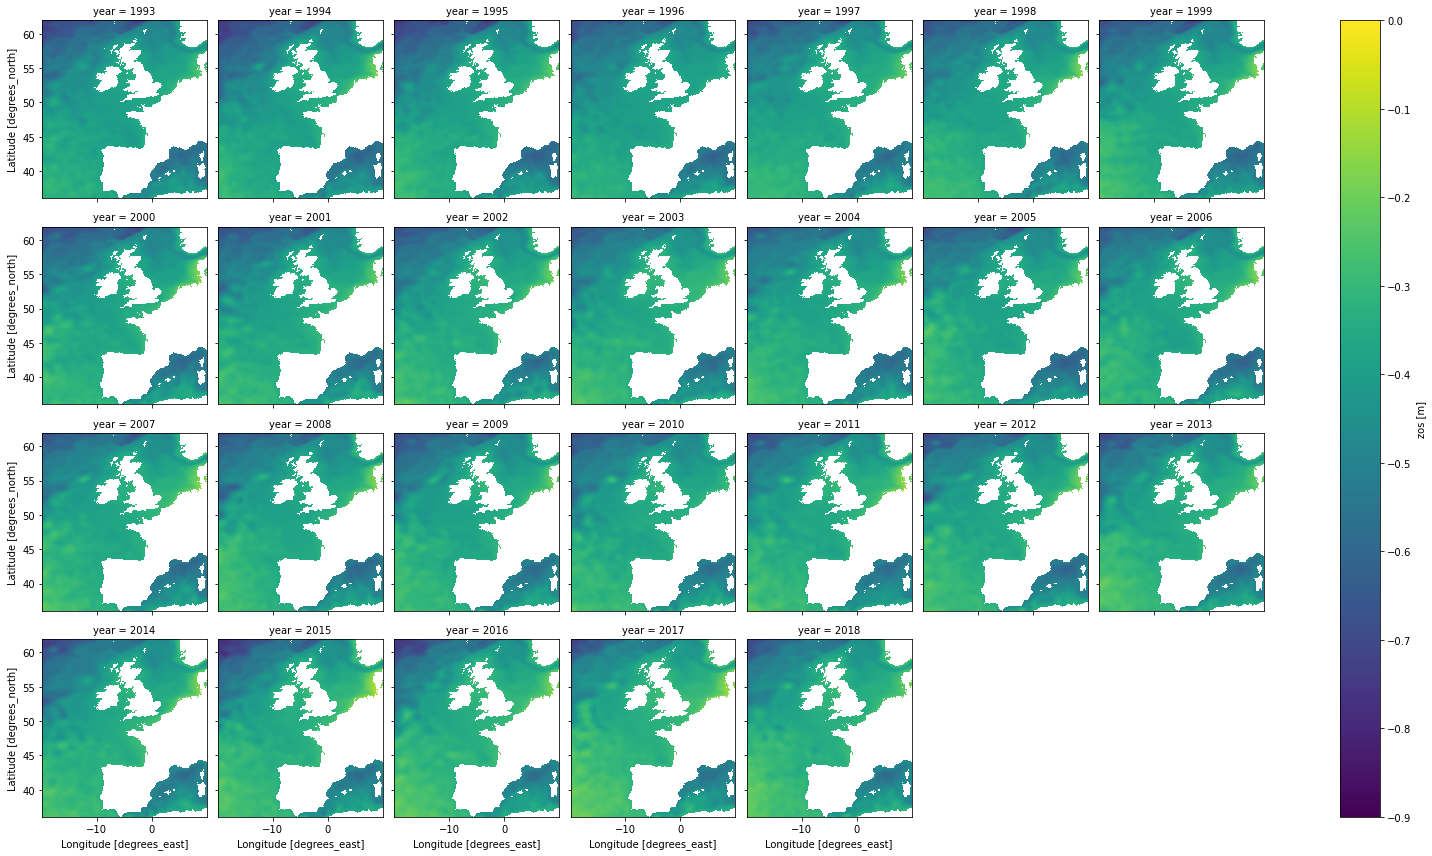

In [69]:
glorys12v1.zos.plot(col = 'year', col_wrap = 7, vmin = -0.9, vmax = 0) # Sea level [m]
plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/reanalysis_vs_roms/glorys12v1maps')

In [70]:
# Import ROMS output from tim
roms_output_tim = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/Tim/ROMS_output_tim.nc')


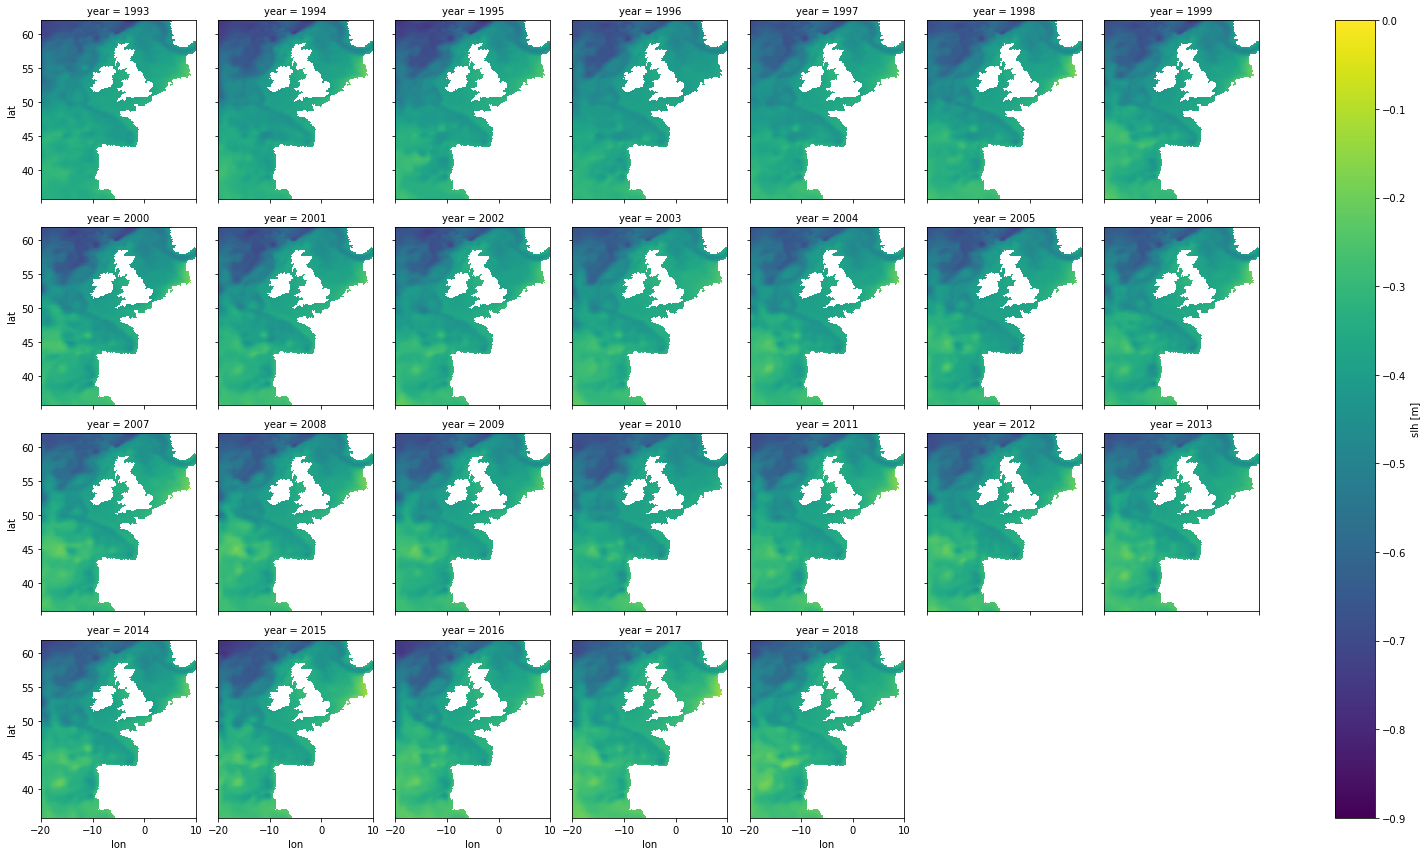

In [71]:
roms_output_tim.slh.plot(col = 'year', col_wrap = 7, vmin = -0.9, vmax = 0) # Sea level [m]
plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/reanalysis_vs_roms/romstimmaps')

In [72]:
# Import altimetry data
cmems_altimetry = xr.open_mfdataset('/Users/iriskeizer/Documents/ROMS/data/CMEMS altimetry/*.nc', parallel = True)

# Obtain annual averages
cmems_altimetry = cmems_altimetry.groupby('time.year').mean()

# Add attributes
cmems_altimetry.adt.attrs['units'] = "m"
cmems_altimetry.adt.attrs['long name'] = "Sea level height above the geoid"


In [73]:
cmems_altimetry

<xarray.Dataset>
Dimensions:    (year: 28, latitude: 208, longitude: 241)
Coordinates:
  * latitude   (latitude) float32 36.06 36.19 36.31 36.44 ... 61.69 61.81 61.94
  * longitude  (longitude) float32 -20.06 -19.94 -19.81 ... 9.688 9.812 9.938
  * year       (year) int64 1993 1994 1995 1996 1997 ... 2017 2018 2019 2020
Data variables:
    adt        (year, latitude, longitude) float64 dask.array<chunksize=(1, 208, 241), meta=np.ndarray>
    crs        (year) float64 -2.147e+09 -2.147e+09 ... -2.147e+09 -2.147e+09

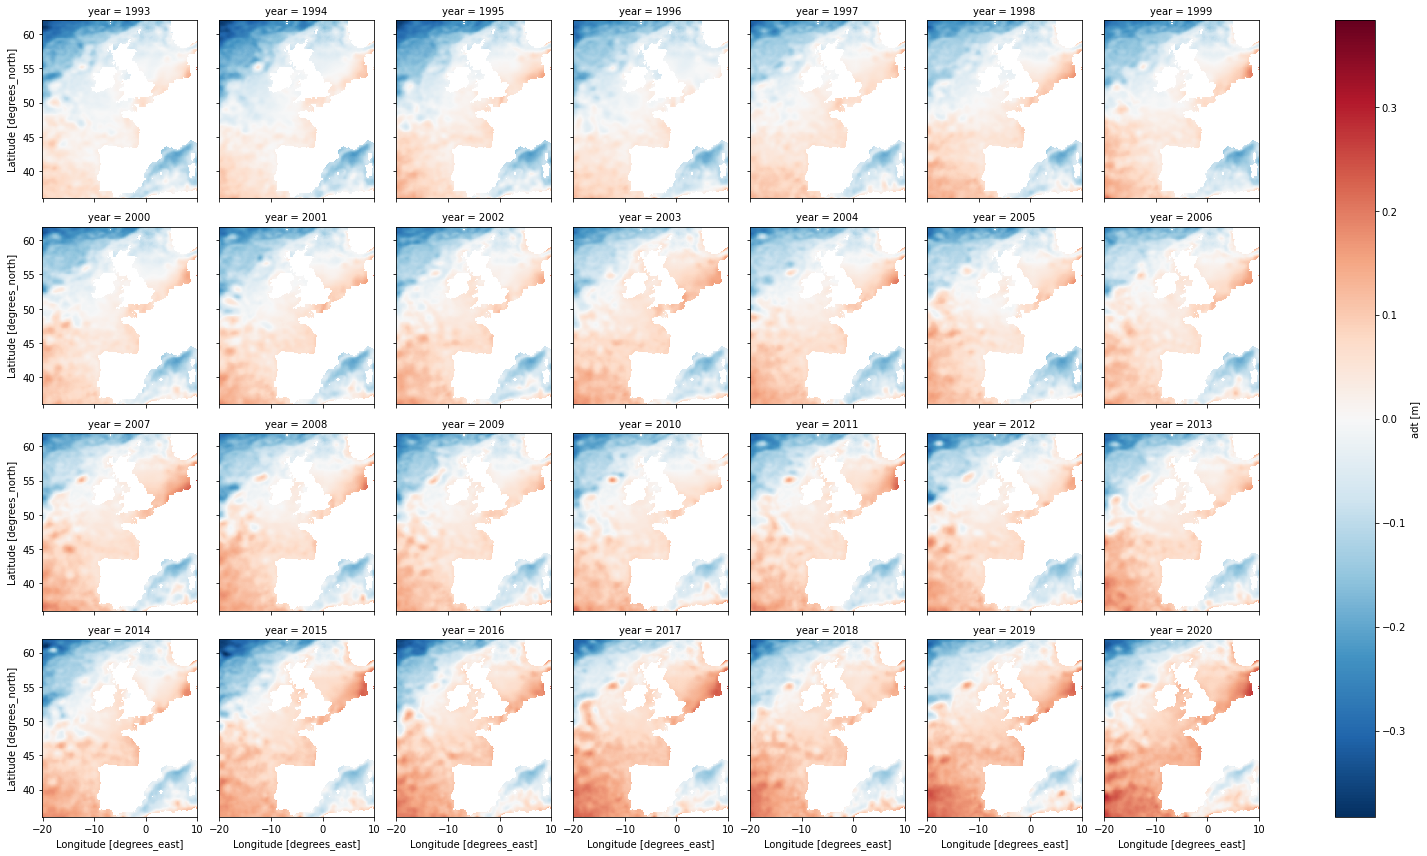

In [74]:
cmems_altimetry.adt.plot(col = 'year', col_wrap = 7) # Sea level [m]
plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/reanalysis_vs_roms/cmemsmaps')

In [75]:
def figure_ssh(data_lst, label_lst, fig_title, fig_name, trends = True):
    '''
    Function that creates a figure of the SSH over time and the trend of SSH
    data_lst should be a list containing the various data sets that should be plotted
    
    '''
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    

    plt.figure(figsize = (10,7))
    
    # Obtain trends
    res_lst = [linregress(data.year, data.values) for data in data_lst]
    trend_lst = [res.slope for res in res_lst]
    se_lst = [res.stderr for res in res_lst]
    
    plt.axhline(color='k', linestyle='--', linewidth = 1.5)
    
    for i, data in enumerate(data_lst):
        
        # Plot the data
        plt.plot(data.year, data.values, linewidth = 2.3, label = label_lst[i] + f' ({round(trend_lst[i]*10, 1)} ± {round(se_lst[i]*10, 1)} mm/y)')
        
        # Plot its trend in the same color
        if trends:
            plt.plot(data.year, res_lst[i].intercept + trend_lst[i] * data.year, colors[i], linestyle = '--', linewidth = 2.3)
        
        plt.xlabel('Time [y]', fontsize =  14)
        plt.ylabel('SSH above the geoid [cm]', fontsize = 14)
        plt.title(fig_title, fontsize = 14)

        plt.legend(fontsize = 14)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)

        plt.savefig(f'/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/reanalysis_vs_roms/{fig_name}')

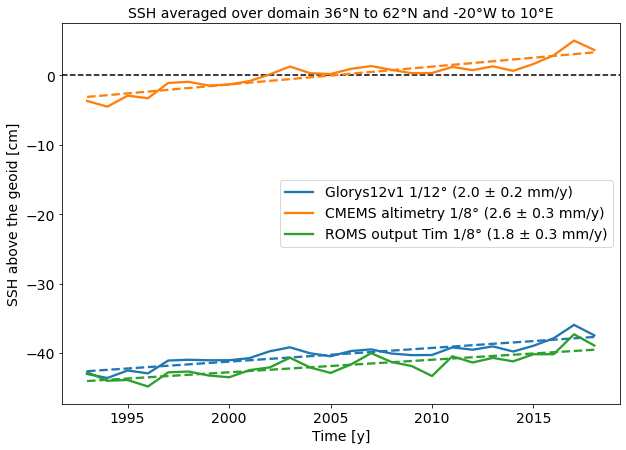

In [76]:
figure_ssh([glorys12v1.zos.mean('longitude').mean('latitude')*f_cm, cmems_altimetry.where(cmems_altimetry.year <= 2018, drop = True).adt.mean('longitude').mean('latitude')*f_cm, roms_output_tim.slh.mean('lat').mean('lon')*f_cm],
          ['Glorys12v1 1/12°', 'CMEMS altimetry 1/8°', 'ROMS output Tim 1/8°'],
           'SSH averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_area_averaged_ssh_glorys12_timoutput8')

In [77]:
# Obtain anomalies
glorys_anom = glorys12v1.zos.mean('longitude').mean('latitude') - glorys12v1.mean('longitude').zos.mean('latitude').mean('year')
roms_tim_anom = roms_output_tim.slh.mean('lat').mean('lon') - roms_output_tim.slh.mean('lat').mean('lon').mean('year')
cmems_anom = cmems_altimetry.where(cmems_altimetry.year <= 2018, drop = True).adt.mean('longitude').mean('latitude') - cmems_altimetry.where(cmems_altimetry.year <= 2018, drop = True).adt.mean('longitude').mean('latitude').mean('year')

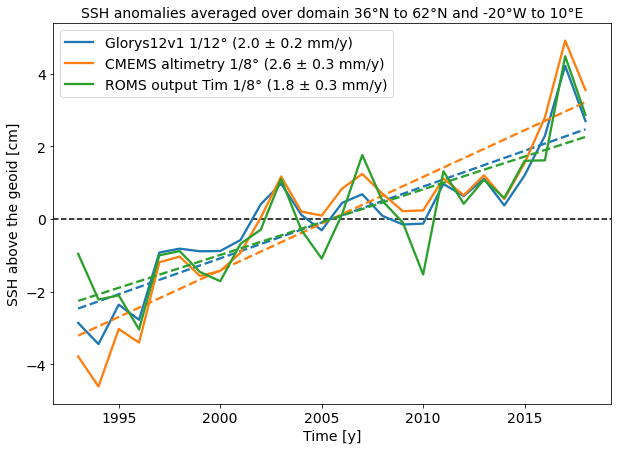

In [78]:
figure_ssh([glorys_anom*f_cm, cmems_anom*f_cm, roms_tim_anom*f_cm],
          ['Glorys12v1 1/12°', 'CMEMS altimetry 1/8°', 'ROMS output Tim 1/8°'],
           'SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E',
           'roms_area_averaged_ssh_anomalies_glorys12_timoutput8')

In [79]:
# Import GLORYS2V3
Glorys2v3 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/GLORYS2V3_shr.nc')

# Make extent of the Glorys12v1 data similar to ROMS
Glorys2v3 = Glorys2v3.where((36 < Glorys2v3.nav_lat) & (62 > Glorys2v3.nav_lat) & (-20 < Glorys2v3.nav_lon) & (10 > Glorys2v3.nav_lon), drop = True)



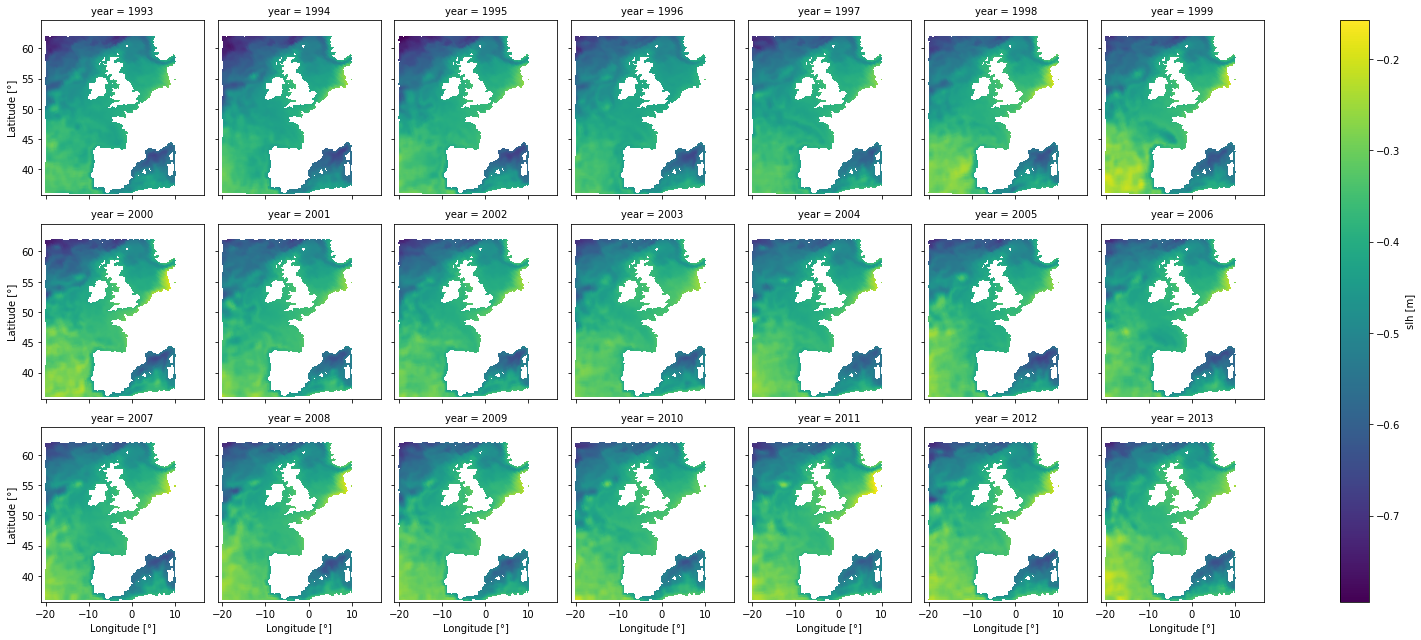

In [80]:
Glorys2v3.slh.plot(x = 'nav_lon', y = 'nav_lat', col = 'year', col_wrap = 7)
plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/reanalysis_vs_roms/glorys2v3maps')

In [81]:
# Import ROMS output dewi
roms_output_dewi4_exp29 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output Dewi/ROMS_output_dewi4_exp29.nc')
roms_output_dewi4_exp36 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output Dewi/ROMS_output_dewi4_exp36.nc')
roms_output_dewi8 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output Dewi/ROMS_output_dewi8.nc')


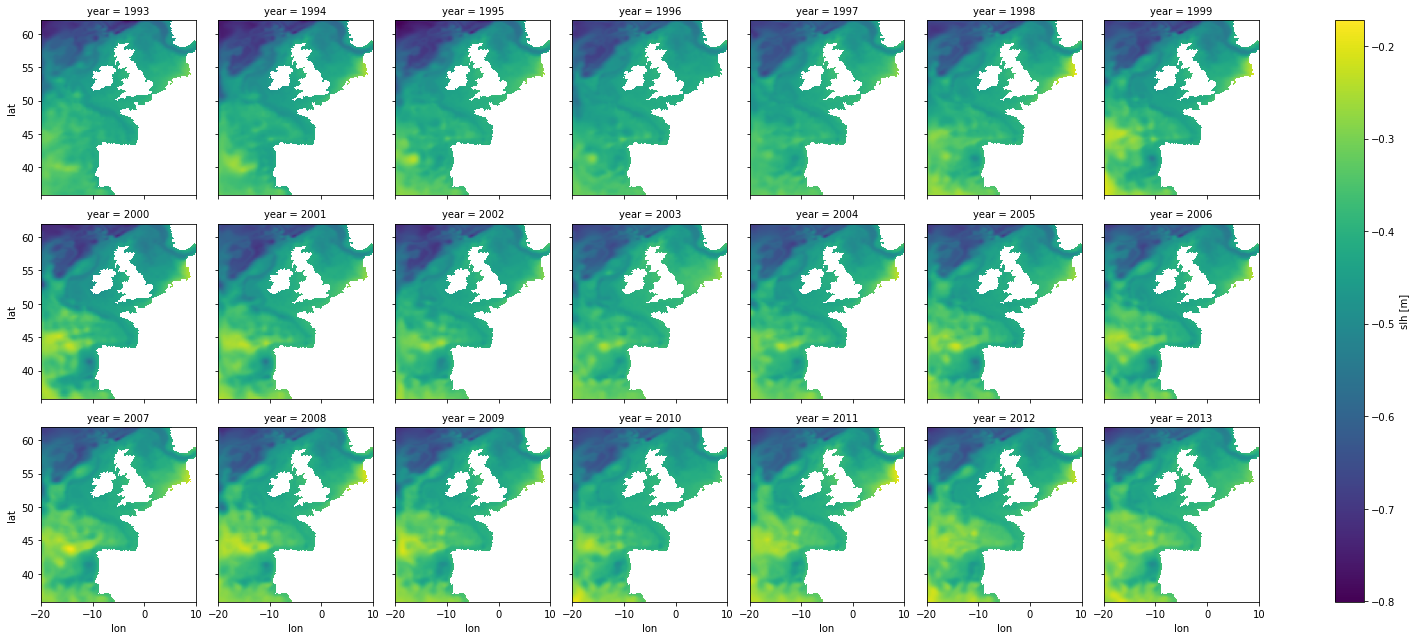

In [82]:
roms_output_dewi8.slh.plot(col = 'year', col_wrap = 7)
plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/reanalysis_vs_roms/romsdewi8maps')

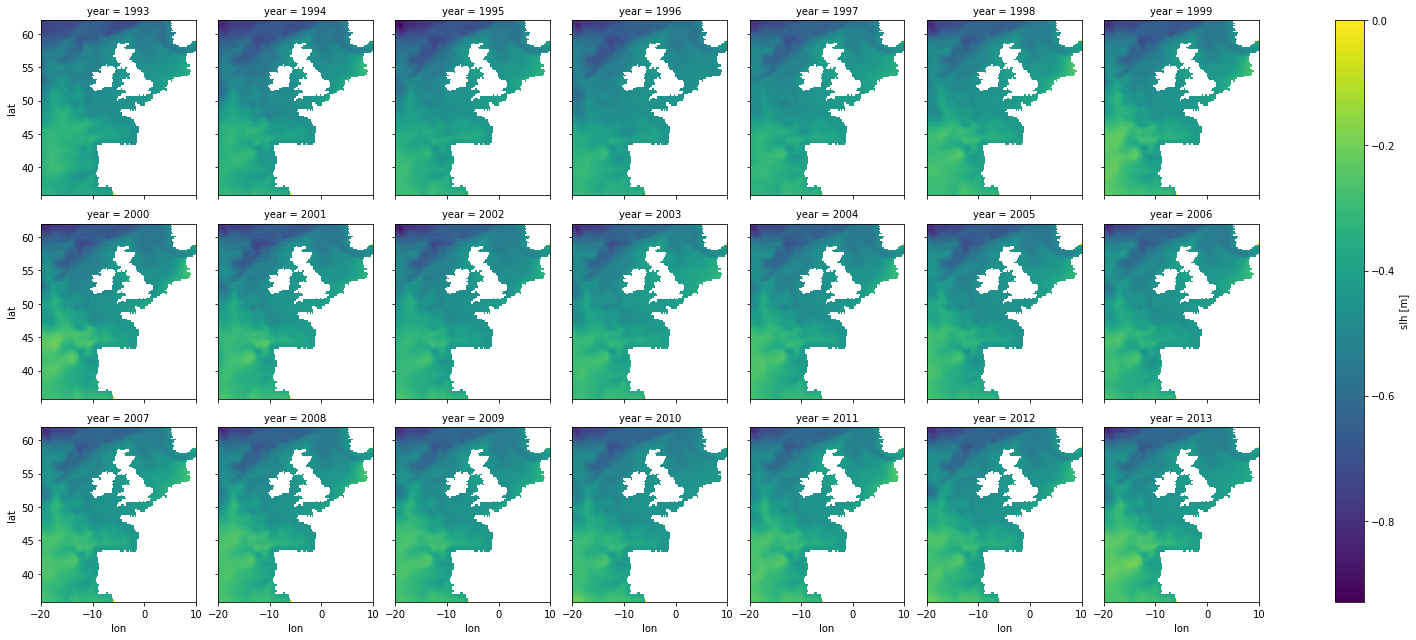

In [83]:
roms_output_dewi4_exp29.slh.plot(col = 'year', col_wrap = 7)
plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/reanalysis_vs_roms/romsdewi429maps')

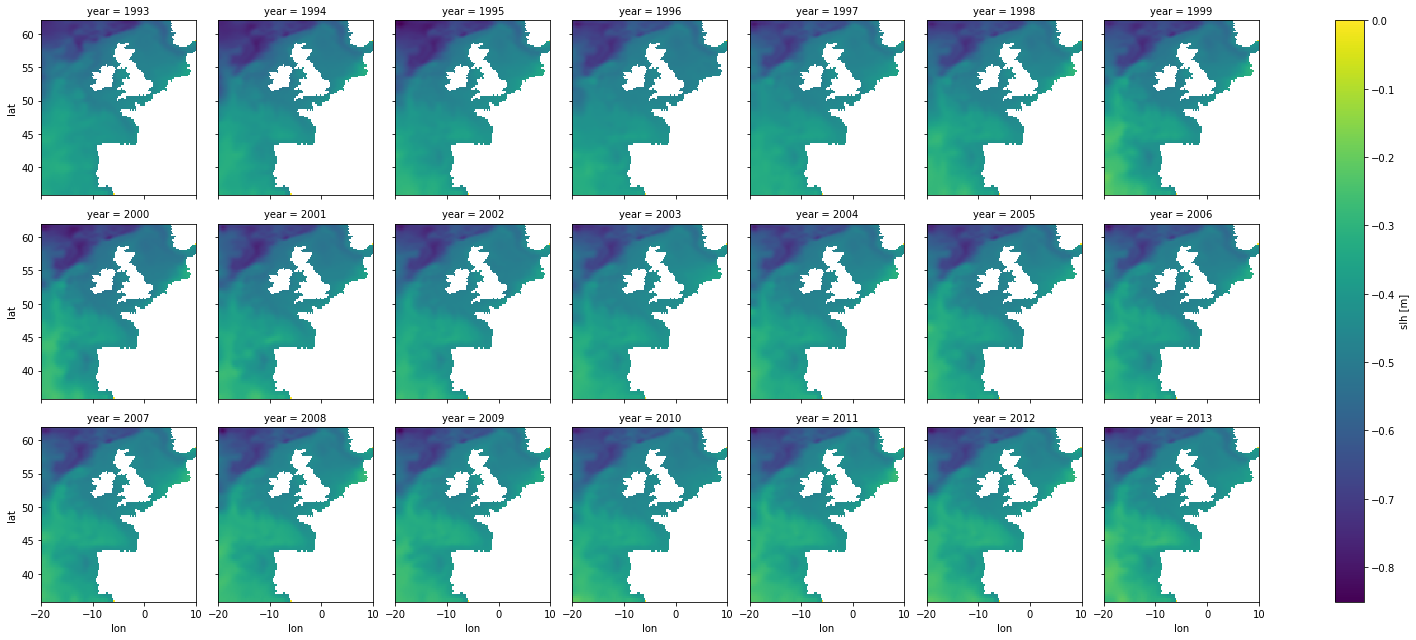

In [84]:
roms_output_dewi4_exp36.slh.plot(col = 'year', col_wrap = 7)
plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/reanalysis_vs_roms/romsdewi436maps')

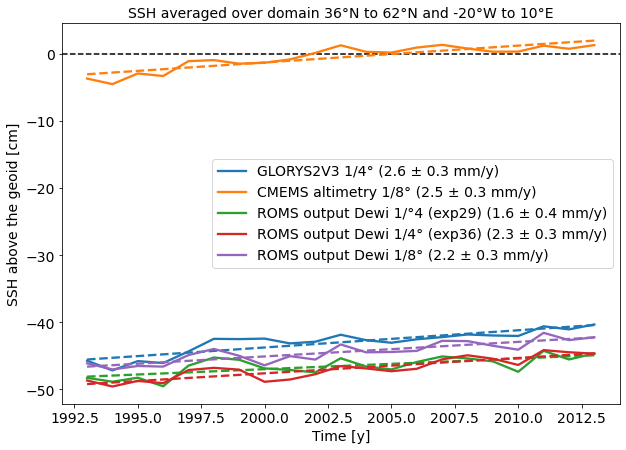

In [85]:
figure_ssh([Glorys2v3.slh.mean('x').mean('y')*f_cm, cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).adt.mean('longitude').mean('latitude')*f_cm, roms_output_dewi4_exp29.slh.mean('lat').mean('lon')*f_cm, 
            roms_output_dewi4_exp36.slh.mean('lat').mean('lon')*f_cm, roms_output_dewi8.slh.mean('lat').mean('lon')*f_cm],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/°4 (exp29)', 'ROMS output Dewi 1/4° (exp36)', 'ROMS output Dewi 1/8°'],
           'SSH averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_area_averaged_ssh_glorys2v3_dewioutput')

In [86]:
# Obtain anomalies
roms4_exp29_anom = roms_output_dewi4_exp29.slh.mean('lat').mean('lon') - roms_output_dewi4_exp29.slh.mean('lat').mean('lon').mean('year')
roms4_exp36_anom = roms_output_dewi4_exp36.slh.mean('lat').mean('lon') - roms_output_dewi4_exp36.slh.mean('lat').mean('lon').mean('year')
roms8_anom = roms_output_dewi8.slh.mean('lat').mean('lon') - roms_output_dewi8.slh.mean('lat').mean('lon').mean('year')
cmems_anom = cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).adt.mean('longitude').mean('latitude') - cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).adt.mean('longitude').mean('latitude').mean('year')
glorys2v3_anom = Glorys2v3.slh.mean('x').mean('y') - Glorys2v3.slh.mean('x').mean('y').mean('year')

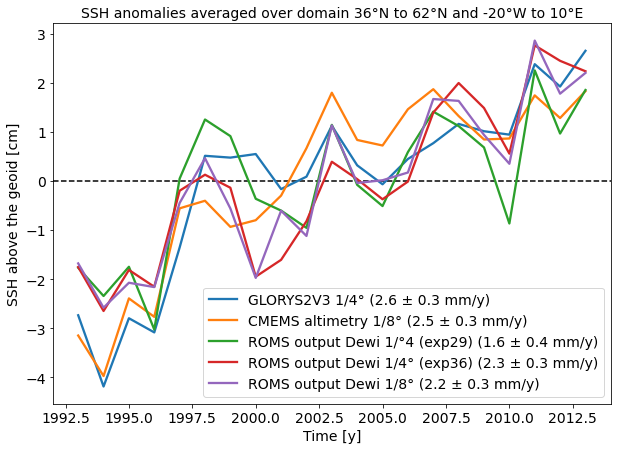

In [87]:
figure_ssh([glorys2v3_anom*f_cm, cmems_anom*f_cm, roms4_exp29_anom*f_cm, roms4_exp36_anom*f_cm, roms8_anom*f_cm],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/°4 (exp29)', 'ROMS output Dewi 1/4° (exp36)', 'ROMS output Dewi 1/8°'],
           'SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_area_averaged_ssh_anomalies_glorys2v3_dewioutput', trends = False)

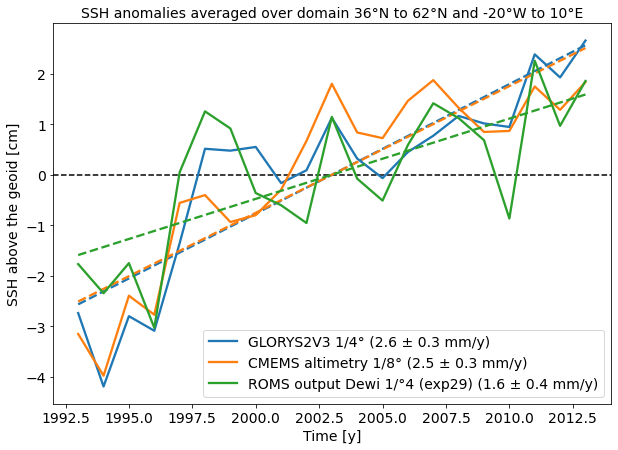

In [88]:
figure_ssh([glorys2v3_anom*f_cm, cmems_anom*f_cm, roms4_exp29_anom*f_cm],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/°4 (exp29)'],
           'SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_area_averaged_ssh_anomalies_glorys2v3_dewioutput_4_29')

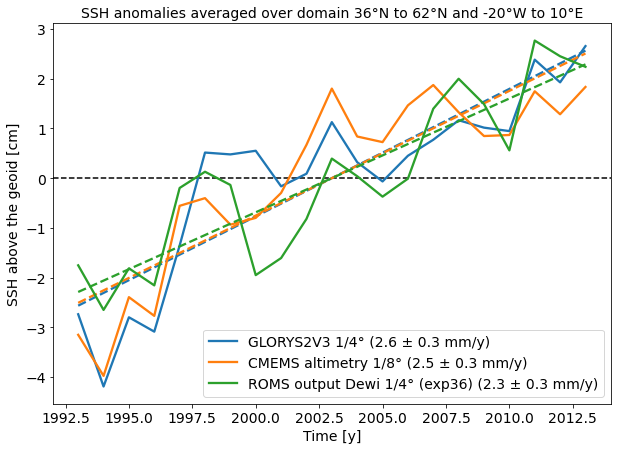

In [89]:
figure_ssh([glorys2v3_anom*f_cm, cmems_anom*f_cm, roms4_exp36_anom*f_cm],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/4° (exp36)'],
           'SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_area_averaged_ssh_anomalies_glorys2v3_dewioutput_4_36')

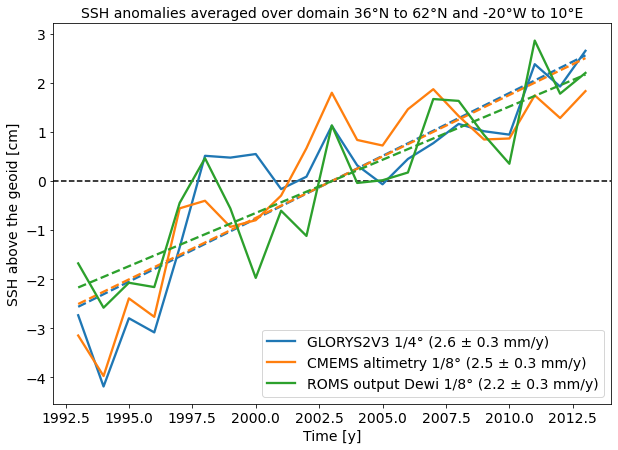

In [90]:
figure_ssh([glorys2v3_anom*f_cm, cmems_anom*f_cm, roms8_anom*f_cm],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/8°'],
           'SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_area_averaged_ssh_anomalies_glorys2v3_dewioutput_8')

## SSH along the Dutch coast

#### For the Tim output and GLORYS12V1 data

In [91]:
# Import tide gauge coordinates
tg_coords = pd.read_csv('/Users/iriskeizer/Documents/Wind effect/Data/observations/Coordinates/tgstations.csv', index_col = 'station')

In [92]:
tg_coords

lat       lon
station                             
Vlissingen       51.442222  3.596111
Hoek v. Holland  51.977500  4.120000
Den Helder       52.964444  4.745000
Delfzijl         53.326389  6.933056
Harlingen        53.175556  5.409444
IJmuiden         52.462222  4.554722

In [93]:
# Create coordinates shifted toward sea
tg_coords_sea = tg_coords.copy()

In [94]:
tg_coords_sea['lat'] = [51.6, 52.1, 52.964444, 53.5, 53.2, 52.462222]
tg_coords_sea['lon'] = [3.5, 3.9, 4.6, 6.933056, 5.3, 4.4]

In [95]:
# Create DataFrame containing the timeseries along the Dutch coast for each tide gauge station for the Glorys12v1 data

glorys12v1_stations = pd.DataFrame({'year':glorys12v1.zos.year.values})
glorys12v1_stations = glorys12v1_stations.set_index('year')

for station in tg_coords.index:
    
    glorys12v1_stations[station] = glorys12v1.zos.sel(latitude = tg_coords_sea['lat'][station], longitude = tg_coords_sea['lon'][station], method = 'Nearest').values
    
# obtain average
glorys12v1_stations['Average'] = glorys12v1_stations.mean(axis=1)

In [96]:
glorys12v1_stations

Vlissingen  Hoek v. Holland  Den Helder  Delfzijl  Harlingen  IJmuiden  \
year                                                                           
1993   -0.304931        -0.308542   -0.303659 -0.273700  -0.286391 -0.298776   
1994   -0.263197        -0.268894   -0.255084 -0.223523  -0.237332 -0.251549   
1995   -0.276472        -0.278481   -0.277998 -0.243690  -0.261238 -0.272734   
1996   -0.346767        -0.343664   -0.346004 -0.341578  -0.339086 -0.342672   
1997   -0.286671        -0.288069   -0.281559 -0.251040  -0.265638 -0.278837   
1998   -0.255211        -0.258721   -0.244860 -0.206305  -0.224108 -0.240562   
1999   -0.262688        -0.268181   -0.253253 -0.212638  -0.231712 -0.249947   
2000   -0.251218        -0.258695   -0.239418 -0.203075  -0.219962 -0.238375   
2001   -0.264570        -0.268868   -0.266783 -0.239519  -0.251040 -0.259585   
2002   -0.265689        -0.266630   -0.252286 -0.232805  -0.239062 -0.251778   
2003   -0.277362        -0.274641   -0.268843 -0.235247  -0.250811 -0.266783   
2004   -0.263197        -0.267520   -0.257729 -0.218869  -0.237409 -0.252490   
2005   -0.286823        -0.288934   -0.287662 -0.250303  -0.267800 -0.281762   
2006   -0.261340        -0.261493   -0.250481 -0.216325  -0.232119 -0.248395   
2007   -0.249336        -0.254448   -0.246462 -0.199973  -0.224616 -0.242266   
2008   -0.266808        -0.269962   -0.250608 -0.212587  -0.231305 -0.250379   
2009   -0.277973        -0.283873   -0.269377 -0.241351  -0.252541 -0.268385   
2010   -0.305083        -0.301726   -0.308364 -0.294173  -0.297454 -0.301879   
2011   -0.245903        -0.252235   -0.230593 -0.186595  -0.208009 -0.231585   
2012   -0.261264        -0.264061   -0.250506 -0.215995  -0.231508 -0.247174   
2013   -0.272785        -0.272759   -0.268080 -0.246361  -0.256406 -0.264341   
2014   -0.242113        -0.244886   -0.228762 -0.206483  -0.214749 -0.228304   
2015   -0.216656        -0.220318   -0.200481 -0.151855  -0.175965 -0.199744   
2016   -0.245216        -0.247022   -0.238604 -0.210120  -0.222480 -0.235120   
2017   -0.221005        -0.226651   -0.214672 -0.166478  -0.190232 -0.209967   
2018   -0.279092        -0.278456   -0.271055 -0.250888  -0.258110 -0.269529   

       Average  
year            
1993 -0.296000  
1994 -0.249930  
1995 -0.268436  
1996 -0.343295  
1997 -0.275302  
1998 -0.238294  
1999 -0.246403  
2000 -0.235124  
2001 -0.258394  
2002 -0.251375  
2003 -0.262281  
2004 -0.249535  
2005 -0.277214  
2006 -0.245025  
2007 -0.236184  
2008 -0.246941  
2009 -0.265583  
2010 -0.301447  
2011 -0.225820  
2012 -0.245085  
2013 -0.263455  
2014 -0.227549  
2015 -0.194170  
2016 -0.233094  
2017 -0.204834  
2018 -0.267855

In [97]:
# Create DataFrame containing the timeseries along the Dutch coast for each tide gauge station for the ROMS output data from Tim

roms_output_tim_stations = pd.DataFrame({'year':roms_output_tim.slh.year.values})
roms_output_tim_stations = roms_output_tim_stations.set_index('year')

for station in tg_coords.index:
    
    roms_output_tim_stations[station] = roms_output_tim.slh.sel(lat = tg_coords_sea['lat'][station], lon = tg_coords_sea['lon'][station], method = 'Nearest').values
    
# obtain average
roms_output_tim_stations['Average'] = roms_output_tim_stations.mean(axis=1)

In [98]:
roms_output_tim_stations

Vlissingen  Hoek v. Holland  Den Helder  Delfzijl  Harlingen  IJmuiden  \
year                                                                           
1993   -0.314686        -0.310295   -0.297838 -0.261859  -0.264440 -0.300256   
1994   -0.305352        -0.297381   -0.282926 -0.242437  -0.243143 -0.285027   
1995   -0.316709        -0.311763   -0.301573 -0.271367  -0.271790 -0.304903   
1996   -0.383490        -0.383092   -0.375975 -0.373564  -0.359973 -0.380370   
1997   -0.336675        -0.328027   -0.311386 -0.272097  -0.280557 -0.318801   
1998   -0.293415        -0.285531   -0.273067 -0.225147  -0.227811 -0.273165   
1999   -0.321133        -0.313654   -0.297504 -0.251235  -0.256689 -0.301488   
2000   -0.314064        -0.306404   -0.291235 -0.246440  -0.247067 -0.292620   
2001   -0.308109        -0.304492   -0.298660 -0.267569  -0.268001 -0.297741   
2002   -0.320442        -0.315669   -0.303705 -0.277308  -0.270177 -0.305595   
2003   -0.323975        -0.316404   -0.305156 -0.271810  -0.275163 -0.310781   
2004   -0.314634        -0.306529   -0.292635 -0.249744  -0.252054 -0.295378   
2005   -0.330931        -0.325736   -0.314912 -0.277449  -0.281919 -0.317358   
2006   -0.314927        -0.304773   -0.289894 -0.250738  -0.253011 -0.294855   
2007   -0.287458        -0.280264   -0.266833 -0.224589  -0.232969 -0.270541   
2008   -0.308314        -0.300523   -0.283453 -0.238485  -0.242331 -0.287271   
2009   -0.325778        -0.319179   -0.302776 -0.269041  -0.268072 -0.308219   
2010   -0.356792        -0.357081   -0.352530 -0.339106  -0.335381 -0.354820   
2011   -0.294050        -0.283440   -0.261459 -0.215660  -0.220709 -0.268614   
2012   -0.307023        -0.299924   -0.287366 -0.246070  -0.248825 -0.290423   
2013   -0.335558        -0.330640   -0.317322 -0.292605  -0.291285 -0.322553   
2014   -0.317302        -0.308773   -0.290868 -0.256640  -0.254387 -0.296101   
2015   -0.281596        -0.269909   -0.247080 -0.187334  -0.199819 -0.253497   
2016   -0.304434        -0.298904   -0.287112 -0.251022  -0.251005 -0.290260   
2017   -0.257354        -0.248655   -0.235703 -0.182674  -0.188285 -0.238736   
2018   -0.325233        -0.317578   -0.305606 -0.284797  -0.281598 -0.311571   

       Average  
year            
1993 -0.291562  
1994 -0.276044  
1995 -0.296351  
1996 -0.376078  
1997 -0.307924  
1998 -0.263023  
1999 -0.290284  
2000 -0.282972  
2001 -0.290762  
2002 -0.298816  
2003 -0.300548  
2004 -0.285162  
2005 -0.308051  
2006 -0.284700  
2007 -0.260442  
2008 -0.276729  
2009 -0.298844  
2010 -0.349285  
2011 -0.257322  
2012 -0.279939  
2013 -0.314994  
2014 -0.287345  
2015 -0.239873  
2016 -0.280456  
2017 -0.225234  
2018 -0.304397

Currently these dataframes also contain nan values which could be improved

either by making sure nearest non-nan data is selected
or take for all dataframes a few stations with non-nan values

In [99]:
# Create DataFrame containing the timeseries along the Dutch coast for each tide gauge station for the ROMS output data from Tim

cmems_altimetry_stations = pd.DataFrame({'year':cmems_altimetry.year.values})
cmems_altimetry_stations = cmems_altimetry_stations.set_index('year')

for station in tg_coords.index:
    
    cmems_altimetry_stations[station] = cmems_altimetry.adt.sel(latitude = tg_coords_sea['lat'][station], longitude = tg_coords_sea['lon'][station], method = 'Nearest').values
    
# obtain average
cmems_altimetry_stations['Average'] = cmems_altimetry_stations.mean(axis=1)

In [100]:
cmems_altimetry_stations

Vlissingen  Hoek v. Holland  Den Helder  Delfzijl  Harlingen  IJmuiden  \
year                                                                           
1993    0.067714         0.060170    0.037424  0.064868   0.039743  0.047290   
1994    0.021450         0.049272    0.074048  0.090729   0.065970  0.070447   
1995    0.046779         0.057004    0.073266  0.119791   0.095303  0.058208   
1996    0.040304        -0.000954   -0.024925  0.001170  -0.017313 -0.022977   
1997    0.065447         0.067769    0.065061  0.075677   0.059182  0.071591   
1998    0.099154         0.092659    0.097327  0.144069   0.114336  0.094460   
1999    0.089403         0.104796    0.087441  0.118555   0.092839  0.099311   
2000    0.052637         0.068474    0.083063  0.109143   0.084347  0.083699   
2001    0.079553         0.077335    0.085161  0.131005   0.085179  0.086282   
2002    0.041837         0.069862    0.082651  0.101595   0.080951  0.086757   
2003    0.108378         0.111095    0.100973  0.152563   0.113824  0.098953   
2004    0.092731         0.090922    0.101399  0.145610   0.111789  0.105752   
2005    0.123222         0.088963    0.073729  0.123037   0.092368  0.073641   
2006    0.109442         0.092479    0.095888  0.152361   0.116597  0.085128   
2007    0.121616         0.147644    0.160814  0.190053   0.164781  0.171425   
2008    0.083750         0.089527    0.107601  0.135777   0.110952  0.108607   
2009    0.083444         0.055706    0.076164  0.100715   0.095567  0.047555   
2010    0.089748         0.095425    0.062202  0.097188   0.072359  0.069590   
2011    0.108604         0.116616    0.114137  0.131381   0.118902  0.108634   
2012    0.126716         0.079357    0.069838  0.102624   0.074683  0.072109   
2013    0.104613         0.075842    0.074565  0.115559   0.069987  0.073773   
2014    0.132264         0.100523    0.082356  0.117492   0.079291  0.098387   
2015    0.169458         0.146684    0.118235  0.178658   0.134597  0.119564   
2016    0.165981         0.123146    0.143308  0.143747   0.139475  0.120628   
2017    0.206684         0.192438    0.165999  0.194856   0.155107  0.192736   
2018    0.127142         0.075413    0.079217  0.095902   0.081524  0.071220   
2019    0.199653         0.146327    0.146966  0.165324   0.137477  0.147696   
2020    0.148372         0.162570    0.160997  0.187209   0.166213  0.159488   

       Average  
year            
1993  0.052868  
1994  0.061986  
1995  0.075058  
1996 -0.004116  
1997  0.067455  
1998  0.107001  
1999  0.098724  
2000  0.080227  
2001  0.090753  
2002  0.077276  
2003  0.114298  
2004  0.108034  
2005  0.095827  
2006  0.108649  
2007  0.159389  
2008  0.106036  
2009  0.076525  
2010  0.081085  
2011  0.116379  
2012  0.087555  
2013  0.085723  
2014  0.101719  
2015  0.144533  
2016  0.139381  
2017  0.184637  
2018  0.088403  
2019  0.157241  
2020  0.164141

In [101]:
def figure_ssh_coast(data_lst, label_lst, fig_title, fig_name, trends = True):
    '''
    Function that creates a figure of the SSH over time and the trend of SSH
    data_lst should be a list containing the various data sets that should be plotted
    
    '''
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    

    plt.figure(figsize = (10,7))
    
    # Obtain trends
    res_lst = [linregress(data.index, data.values) for data in data_lst]
    trend_lst = [res.slope for res in res_lst]
    se_lst = [res.stderr for res in res_lst]
    
    plt.axhline(color='k', linestyle='--', linewidth = 1.5)
    
    for i, data in enumerate(data_lst):
        
        # Plot the data
        plt.plot(data.index, data.values, linewidth = 2.3, label = label_lst[i] + f' ({round(trend_lst[i]*10, 1)} ± {round(se_lst[i]*10, 1)} mm/y)')
        
        # Plot its trend in the same color
        if trends:
            plt.plot(data.index, res_lst[i].intercept + trend_lst[i] * data.index, colors[i], linestyle = '--', linewidth = 2.3)
        
        plt.xlabel('Time [y]', fontsize =  14)
        plt.ylabel('SSH above the geoid [cm]', fontsize = 14)
        plt.title(fig_title, fontsize = 14)

        plt.legend(fontsize = 14)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)

        plt.savefig(f'/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/reanalysis_vs_roms/{fig_name}')

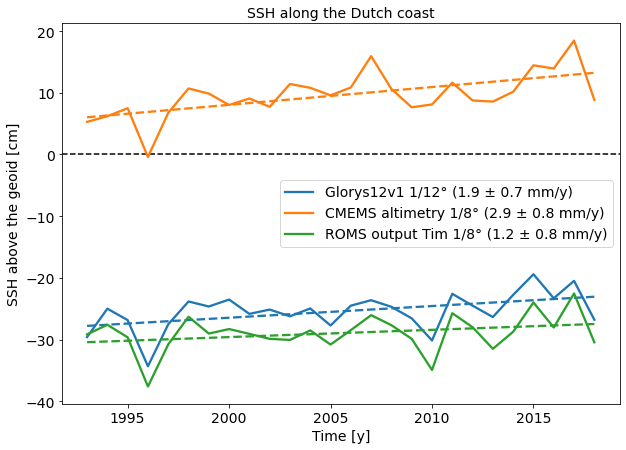

In [102]:
figure_ssh_coast([glorys12v1_stations['Average']*f_cm, cmems_altimetry_stations[:-2]['Average']*f_cm, roms_output_tim_stations['Average']*f_cm],
          ['Glorys12v1 1/12°', 'CMEMS altimetry 1/8°', 'ROMS output Tim 1/8°'],
           'SSH along the Dutch coast',
          'roms_dutch_coast_ssh_glorys12_timoutput8')

In [103]:
# Obtain anomalies by substracting the mean of overlap period
glorys_stat_anom = glorys12v1_stations['Average'] - glorys12v1_stations['Average'].mean()
roms_tim_stat_anom = roms_output_tim_stations['Average'] - roms_output_tim_stations['Average'].mean()
cmems_stat_anom = cmems_altimetry_stations[:-2]['Average'] - cmems_altimetry_stations[:-2]['Average'].mean()

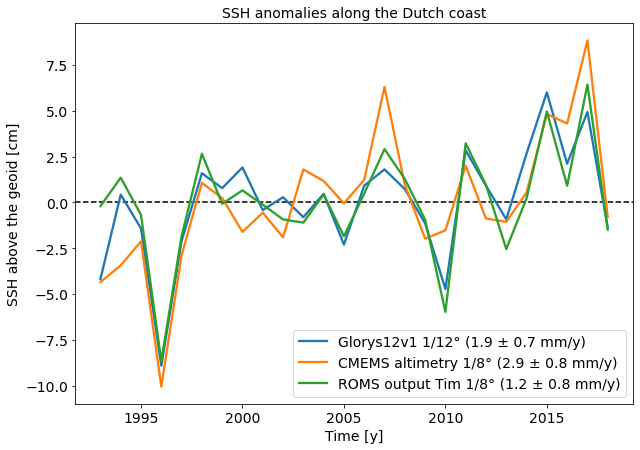

In [104]:
figure_ssh_coast([glorys_stat_anom*f_cm, cmems_stat_anom*f_cm, roms_tim_stat_anom*f_cm],
          ['Glorys12v1 1/12°', 'CMEMS altimetry 1/8°', 'ROMS output Tim 1/8°'],
           'SSH anomalies along the Dutch coast',
          'roms_dutch_coast_ssh_anomalies_glorys12_timoutput8', trends = False)

## SSH along the Dutch coast

#### For Dewi's output and GLORYS2V3 data

In [105]:
# Create coordinates shifted toward sea
tg_coords_sea2 = tg_coords.copy()

tg_coords_sea2['lat'] = [51.6, 52.2, 52.964444, 53.6, 53.2, 52.462222]
tg_coords_sea2['lon'] = [3.3, 3.8, 4.5, 6.933056, 5.2, 4.3]

In [106]:
# Create DataFrame containing the timeseries along the Dutch coast for each tide gauge station for the Glorys12v1 data

glorys2v3_stations = pd.DataFrame({'year':Glorys2v3.year.values})
glorys2v3_stations = glorys2v3_stations.set_index('year')


for station in tg_coords.index:
    
    if station == 'Delfzijl' or  station == 'Harlingen':
        glorys2v3_stations[station] = Glorys2v3.slh.where((tg_coords_sea2['lat'][station]-0.2 < Glorys2v3.nav_lat) & (tg_coords_sea2['lat'][station]+0.2 > Glorys2v3.nav_lat) & (tg_coords_sea2['lon'][station]-0.1  < Glorys2v3.nav_lon) & (tg_coords_sea2['lon'][station]+0.1  > Glorys2v3.nav_lon), drop = True).values.flatten()
    else:
        glorys2v3_stations[station] = Glorys2v3.slh.where((tg_coords_sea2['lat'][station]-0.1 < Glorys2v3.nav_lat) & (tg_coords_sea2['lat'][station]+0.1 > Glorys2v3.nav_lat) & (tg_coords_sea2['lon'][station]-0.1  < Glorys2v3.nav_lon) & (tg_coords_sea2['lon'][station]+0.1  > Glorys2v3.nav_lon), drop = True).values.flatten()
    
# obtain average
glorys2v3_stations['Average'] = glorys2v3_stations.mean(axis=1)

In [107]:
glorys2v3_stations

Vlissingen  Hoek v. Holland  Den Helder  Delfzijl  Harlingen  IJmuiden  \
year                                                                           
1993   -0.345276        -0.346731   -0.342345 -0.330267  -0.338215 -0.329418   
1994   -0.329203        -0.330307   -0.318973 -0.307176  -0.314095 -0.303019   
1995   -0.327271        -0.328686   -0.325917 -0.313268  -0.321756 -0.315216   
1996   -0.394456        -0.396483   -0.397612 -0.397288  -0.395737 -0.389013   
1997   -0.340928        -0.343804   -0.336454 -0.319515  -0.330916 -0.324521   
1998   -0.289883        -0.286432   -0.274401 -0.261208  -0.271490 -0.259490   
1999   -0.299915        -0.296455   -0.282157 -0.264113  -0.276775 -0.267412   
2000   -0.283825        -0.284513   -0.268166 -0.253891  -0.263832 -0.252471   
2001   -0.310345        -0.312911   -0.310419 -0.301196  -0.308412 -0.295315   
2002   -0.309605        -0.309434   -0.297278 -0.290508  -0.295068 -0.285285   
2003   -0.315709        -0.313985   -0.305597 -0.288210  -0.300803 -0.296888   
2004   -0.304990        -0.302469   -0.293301 -0.278434  -0.290400 -0.278446   
2005   -0.324129        -0.324975   -0.323901 -0.311769  -0.322331 -0.309472   
2006   -0.308138        -0.306969   -0.295241 -0.279291  -0.290204 -0.283172   
2007   -0.301263        -0.301650   -0.292551 -0.272507  -0.288023 -0.281406   
2008   -0.295278        -0.293039   -0.275570 -0.258841  -0.270361 -0.263230   
2009   -0.297682        -0.296599   -0.286506 -0.276529  -0.283573 -0.274045   
2010   -0.318376        -0.323830   -0.327967 -0.327830  -0.327747 -0.316941   
2011   -0.261460        -0.256438   -0.240954 -0.223552  -0.235893 -0.228262   
2012   -0.292250        -0.293666   -0.279295 -0.267692  -0.275855 -0.264511   
2013   -0.306476        -0.305835   -0.302718 -0.289666  -0.298950 -0.292443   

       Average  
year            
1993 -0.338709  
1994 -0.317129  
1995 -0.322019  
1996 -0.395098  
1997 -0.332690  
1998 -0.273817  
1999 -0.281138  
2000 -0.267783  
2001 -0.306433  
2002 -0.297863  
2003 -0.303532  
2004 -0.291340  
2005 -0.319430  
2006 -0.293836  
2007 -0.289567  
2008 -0.276053  
2009 -0.285822  
2010 -0.323782  
2011 -0.241093  
2012 -0.278878  
2013 -0.299348

In [108]:
# Create DataFrame containing the timeseries along the Dutch coast for each tide gauge station for the ROMS output data from Dewi

roms_output_dewi8_stations = pd.DataFrame({'year':roms_output_dewi8.year.values})
roms_output_dewi8_stations = roms_output_dewi8_stations.set_index('year')

roms_output_dewi4_exp29_stations = roms_output_dewi8_stations.copy()
roms_output_dewi4_exp36_stations = roms_output_dewi8_stations.copy()


for station in tg_coords.index:
    
    roms_output_dewi8_stations[station] = roms_output_dewi8.slh.sel(lat = tg_coords_sea2['lat'][station], lon = tg_coords_sea2['lon'][station], method = 'Nearest').values
    roms_output_dewi4_exp29_stations[station] = roms_output_dewi4_exp29.slh.sel(lat = tg_coords_sea2['lat'][station], lon = tg_coords_sea2['lon'][station], method = 'Nearest').values
    roms_output_dewi4_exp36_stations[station] = roms_output_dewi4_exp36.slh.sel(lat = tg_coords_sea2['lat'][station], lon = tg_coords_sea2['lon'][station], method = 'Nearest').values
    
# obtain average
roms_output_dewi8_stations['Average'] = roms_output_dewi8_stations.mean(axis=1)
roms_output_dewi4_exp29_stations['Average'] = roms_output_dewi4_exp29_stations.mean(axis=1)
roms_output_dewi4_exp36_stations['Average'] = roms_output_dewi4_exp36_stations.mean(axis=1)

In [109]:
roms_output_dewi4_exp36_stations

Vlissingen  Hoek v. Holland  Den Helder  Delfzijl  Harlingen  IJmuiden  \
year                                                                           
1993   -0.414593        -0.411869   -0.402778 -0.380604  -0.373418 -0.402766   
1994   -0.414970        -0.406129   -0.389584 -0.357626  -0.356527 -0.391425   
1995   -0.404251        -0.399178   -0.389946 -0.363216  -0.358698 -0.390979   
1996   -0.467571        -0.470792   -0.468273 -0.463308  -0.445602 -0.466907   
1997   -0.431578        -0.421620   -0.410363 -0.381871  -0.380888 -0.413521   
1998   -0.387555        -0.376996   -0.360195 -0.324996  -0.325165 -0.362003   
1999   -0.403804        -0.392523   -0.375856 -0.335364  -0.339910 -0.379167   
2000   -0.425063        -0.414485   -0.392811 -0.355512  -0.357454 -0.397308   
2001   -0.417230        -0.414398   -0.407187 -0.382839  -0.377304 -0.405700   
2002   -0.427859        -0.423161   -0.408162 -0.386671  -0.379778 -0.410221   
2003   -0.418162        -0.409167   -0.400122 -0.372370  -0.368788 -0.403196   
2004   -0.401104        -0.388794   -0.374145 -0.336550  -0.339646 -0.376589   
2005   -0.414307        -0.406092   -0.396398 -0.363958  -0.362070 -0.398388   
2006   -0.423655        -0.408586   -0.392309 -0.354727  -0.357526 -0.397106   
2007   -0.382391        -0.373012   -0.359319 -0.321723  -0.325583 -0.362362   
2008   -0.387853        -0.376929   -0.356410 -0.314543  -0.321339 -0.361223   
2009   -0.405519        -0.396503   -0.378821 -0.350372  -0.346463 -0.382776   
2010   -0.432267        -0.433221   -0.430493 -0.416617  -0.405288 -0.429236   
2011   -0.382146        -0.366968   -0.345318 -0.304993  -0.308038 -0.352122   
2012   -0.382454        -0.374510   -0.358179 -0.324799  -0.324022 -0.361401   
2013   -0.412125        -0.411781   -0.403902 -0.385860  -0.377073 -0.404981   

       Average  
year            
1993 -0.397672  
1994 -0.386043  
1995 -0.384378  
1996 -0.463742  
1997 -0.406640  
1998 -0.356152  
1999 -0.371104  
2000 -0.390439  
2001 -0.400776  
2002 -0.405975  
2003 -0.395301  
2004 -0.369471  
2005 -0.390202  
2006 -0.388985  
2007 -0.354065  
2008 -0.353050  
2009 -0.376742  
2010 -0.424520  
2011 -0.343264  
2012 -0.354227  
2013 -0.399287

In [110]:
roms_output_dewi4_exp29_stations

Vlissingen  Hoek v. Holland  Den Helder  Delfzijl  Harlingen  IJmuiden  \
year                                                                           
1993   -0.415556        -0.412136   -0.403143 -0.378949  -0.373272 -0.403763   
1994   -0.397911        -0.388943   -0.371901 -0.337687  -0.336252 -0.374521   
1995   -0.393864        -0.388628   -0.379000 -0.350613  -0.346527 -0.380516   
1996   -0.458373        -0.461670   -0.459617 -0.456115  -0.439467 -0.458416   
1997   -0.405680        -0.396545   -0.384965 -0.354638  -0.355971 -0.388593   
1998   -0.358962        -0.348980   -0.331417 -0.294187  -0.294113 -0.333933   
1999   -0.377735        -0.366946   -0.349260 -0.308051  -0.311728 -0.353416   
2000   -0.390464        -0.381599   -0.359025 -0.320570  -0.321703 -0.363968   
2001   -0.392352        -0.389317   -0.381638 -0.355950  -0.350208 -0.380912   
2002   -0.415772        -0.411526   -0.395546 -0.374172  -0.365865 -0.398410   
2003   -0.390684        -0.381765   -0.372381 -0.343052  -0.341964 -0.375818   
2004   -0.395453        -0.383379   -0.368151 -0.330028  -0.332381 -0.371112   
2005   -0.401409        -0.394032   -0.383879 -0.349461  -0.349953 -0.386136   
2006   -0.395218        -0.380883   -0.363335 -0.324070  -0.328327 -0.368960   
2007   -0.375693        -0.366046   -0.352021 -0.312284  -0.317193 -0.355559   
2008   -0.389455        -0.379042   -0.358053 -0.315239  -0.321768 -0.363173   
2009   -0.407226        -0.399137   -0.381227 -0.350728  -0.348637 -0.385680   
2010   -0.436916        -0.438548   -0.435559 -0.422195  -0.411619 -0.434512   
2011   -0.375484        -0.360252   -0.338050 -0.295779  -0.300893 -0.345422   
2012   -0.391203        -0.384899   -0.368202 -0.333768  -0.332981 -0.371538   
2013   -0.407510        -0.406726   -0.399077 -0.380838  -0.373734 -0.400281   

       Average  
year            
1993 -0.397803  
1994 -0.367869  
1995 -0.373191  
1996 -0.455610  
1997 -0.381065  
1998 -0.326932  
1999 -0.344523  
2000 -0.356221  
2001 -0.375063  
2002 -0.393548  
2003 -0.367611  
2004 -0.363417  
2005 -0.377478  
2006 -0.360132  
2007 -0.346466  
2008 -0.354455  
2009 -0.378773  
2010 -0.429892  
2011 -0.335980  
2012 -0.363765  
2013 -0.394694

In [111]:
roms_output_dewi8_stations

Vlissingen  Hoek v. Holland  Den Helder  Delfzijl  Harlingen  IJmuiden  \
year                                                                           
1993   -0.373639        -0.369595   -0.361851 -0.336326  -0.337866 -0.359322   
1994   -0.363874        -0.352820   -0.340811 -0.305202  -0.308826 -0.336580   
1995   -0.365911        -0.361038   -0.351069 -0.324451  -0.327501 -0.351857   
1996   -0.413678        -0.417776   -0.413494 -0.412683  -0.399578 -0.413711   
1997   -0.378542        -0.369930   -0.355219 -0.325072  -0.333185 -0.359373   
1998   -0.328753        -0.317299   -0.306855 -0.265610  -0.272286 -0.301612   
1999   -0.356894        -0.345776   -0.330819 -0.288001  -0.298764 -0.329851   
2000   -0.375930        -0.364291   -0.349966 -0.304981  -0.314210 -0.345182   
2001   -0.353046        -0.349681   -0.344707 -0.317196  -0.320115 -0.340154   
2002   -0.377737        -0.370447   -0.359925 -0.335344  -0.333722 -0.356178   
2003   -0.359867        -0.351502   -0.339103 -0.311875  -0.316988 -0.344944   
2004   -0.351965        -0.340895   -0.327521 -0.286602  -0.297340 -0.326332   
2005   -0.365205        -0.357739   -0.345572 -0.312624  -0.322161 -0.345596   
2006   -0.371660        -0.356523   -0.340227 -0.302645  -0.311254 -0.342998   
2007   -0.337272        -0.327003   -0.312872 -0.276385  -0.287071 -0.315066   
2008   -0.344794        -0.332875   -0.316674 -0.271733  -0.282926 -0.314351   
2009   -0.364929        -0.356580   -0.338796 -0.307289  -0.310860 -0.338905   
2010   -0.386091        -0.387484   -0.381008 -0.369967  -0.366595 -0.381407   
2011   -0.333269        -0.317005   -0.294379 -0.253055  -0.263827 -0.298093   
2012   -0.345853        -0.337752   -0.325166 -0.287612  -0.294885 -0.323378   
2013   -0.363068        -0.361856   -0.352361 -0.335658  -0.333367 -0.353460   

       Average  
year            
1993 -0.356433  
1994 -0.334686  
1995 -0.346971  
1996 -0.411820  
1997 -0.353553  
1998 -0.298736  
1999 -0.325017  
2000 -0.342427  
2001 -0.337483  
2002 -0.355559  
2003 -0.337380  
2004 -0.321776  
2005 -0.341483  
2006 -0.337551  
2007 -0.309278  
2008 -0.310559  
2009 -0.336226  
2010 -0.378759  
2011 -0.293271  
2012 -0.319108  
2013 -0.349962

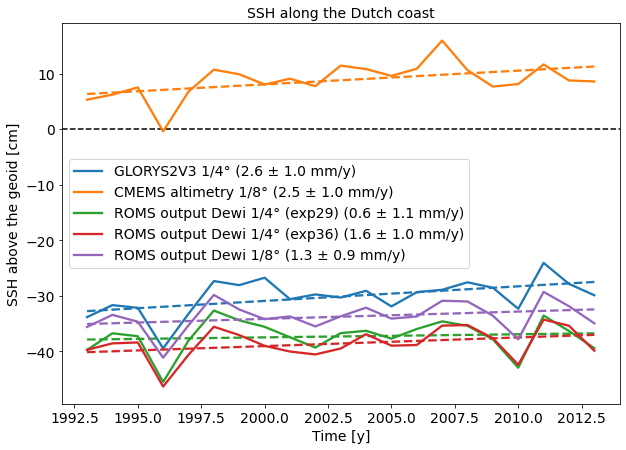

In [112]:
figure_ssh_coast([glorys2v3_stations['Average']*f_cm, cmems_altimetry_stations[:-7]['Average']*f_cm, roms_output_dewi4_exp29_stations['Average']*f_cm, roms_output_dewi4_exp36_stations['Average']*f_cm, roms_output_dewi8_stations['Average']*f_cm],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/4° (exp29)', 'ROMS output Dewi 1/4° (exp36)', 'ROMS output Dewi 1/8°'],
           'SSH along the Dutch coast',
          'roms_dutch_coast_ssh_glorys2v3_dewioutput')

In [113]:
# Obtain anomalies by substracting the mean of overlap period
roms_output_dewi8_stations_anom = roms_output_dewi8_stations['Average'] - roms_output_dewi8_stations['Average'].mean()
roms_output_dewi4_exp29_stations_anom = roms_output_dewi4_exp29_stations['Average'] - roms_output_dewi4_exp29_stations['Average'].mean()
roms_output_dewi4_exp36_stations_anom = roms_output_dewi4_exp36_stations['Average'] - roms_output_dewi4_exp36_stations['Average'].mean()
cmems_stat_anom2 = cmems_altimetry_stations[:-7]['Average'] - cmems_altimetry_stations[:-7]['Average'].mean()
glorys2v3_stat_anom = glorys2v3_stations['Average'] - glorys2v3_stations['Average'].mean()

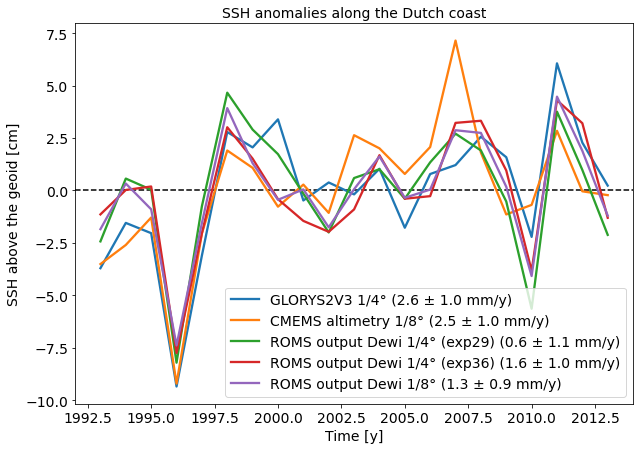

In [114]:
figure_ssh_coast([glorys2v3_stat_anom*f_cm, cmems_stat_anom2*f_cm, roms_output_dewi4_exp29_stations_anom*f_cm, roms_output_dewi4_exp36_stations_anom*f_cm, roms_output_dewi8_stations_anom*f_cm],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/4° (exp29)', 'ROMS output Dewi 1/4° (exp36)', 'ROMS output Dewi 1/8°'],
           'SSH anomalies along the Dutch coast',
          'roms_dutch_coast_ssh_anomalies_glorys2v3_dewioutput', trends = False)

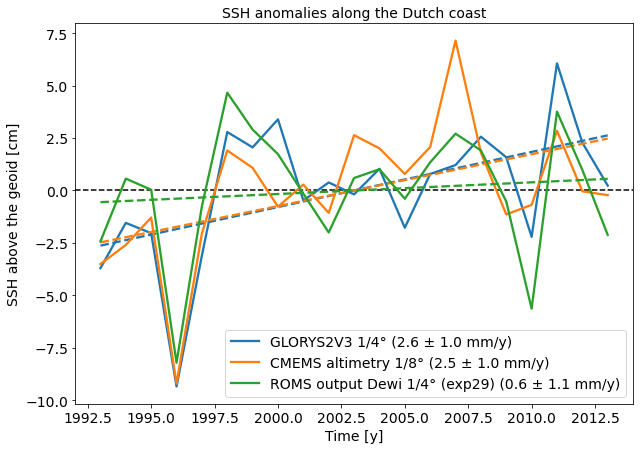

In [115]:
figure_ssh_coast([glorys2v3_stat_anom*f_cm, cmems_stat_anom2*f_cm, roms_output_dewi4_exp29_stations_anom*f_cm],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/4° (exp29)'],
           'SSH anomalies along the Dutch coast',
          'roms_dutch_coast_ssh_anomalies_glorys2v3_dewioutput_4_29')

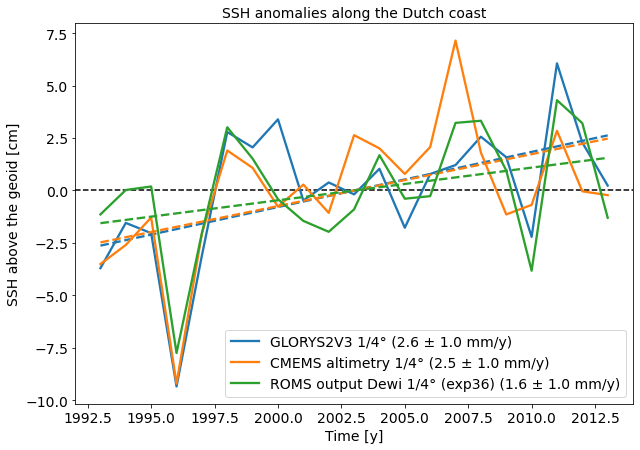

In [116]:
figure_ssh_coast([glorys2v3_stat_anom*f_cm, cmems_stat_anom2*f_cm, roms_output_dewi4_exp36_stations_anom*f_cm],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/4°', 'ROMS output Dewi 1/4° (exp36)'],
           'SSH anomalies along the Dutch coast',
          'roms_dutch_coast_ssh_anomalies_glorys2v3_dewioutput_4_36')

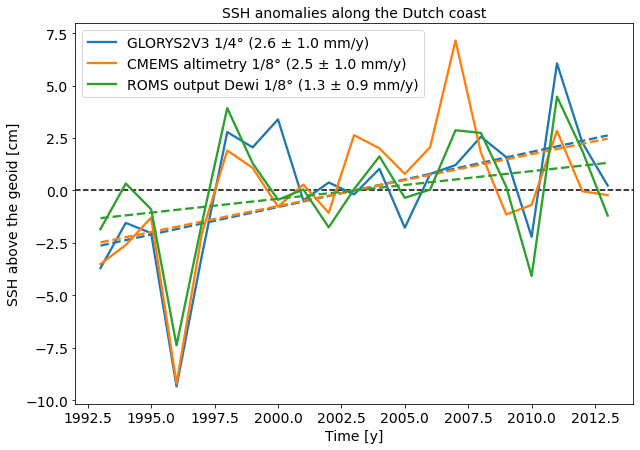

In [117]:
figure_ssh_coast([glorys2v3_stat_anom*f_cm, cmems_stat_anom2*f_cm, roms_output_dewi8_stations_anom*f_cm],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/8°'],
           'SSH anomalies along the Dutch coast',
          'roms_dutch_coast_ssh_anomalies_glorys2v3_dewioutput_8')

## Difference between ROMS averaged sea level and sea level along the Dutch coast

#### For the Tim output and GLORYS12V1 data

In [118]:
def figure_ssh_difference(data_lst, time_lst, label_lst, fig_title, fig_name, trends = True):
    '''
    Function that creates a figure of the SSH over time and the trend of SSH
    data_lst should be a list containing the various data sets that should be plotted
    
    '''
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    

    plt.figure(figsize = (10,7))
    
    # Obtain trends
    res_lst = [linregress(time_lst[i], data) for i, data in enumerate(data_lst)]
    trend_lst = [res.slope for res in res_lst]
    se_lst = [res.stderr for res in res_lst]
    
    
    plt.axhline(color='k', linestyle='--', linewidth = 1.5)
    
    for i, data in enumerate(data_lst):
        
        # Plot the data
        plt.plot(time_lst[i], data, linewidth = 2.3, label = label_lst[i] + f' ({round(trend_lst[i]*10, 1)} ± {round(se_lst[i]*10, 1)} mm/y)')
        
        # Plot its trend in the same color
        if trends:
            plt.plot(time_lst[i], res_lst[i].intercept + trend_lst[i] * time_lst[i], colors[i], linestyle = '--', linewidth = 2.3)
        
        plt.xlabel('Time [y]', fontsize =  14)
        plt.ylabel('SSH above the geoid [cm]', fontsize = 14)
        plt.title(fig_title, fontsize = 14)

        plt.legend(fontsize = 14)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)

        plt.savefig(f'/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/reanalysis_vs_roms/{fig_name}')

In [119]:
# Obtain differences by substracting the sea level along the Dutch coast from the domain mean 

glorys12v1_difference = glorys12v1_stations['Average'].values - glorys12v1.zos.mean('longitude').mean('latitude').values
roms_output_tim_difference = roms_output_tim_stations['Average'].values - roms_output_tim.slh.mean('lat').mean('lon').values
cmems_altimetry_difference = cmems_altimetry_stations[:-2]['Average'].values - cmems_altimetry.where(cmems_altimetry.year <= 2018, drop = True).adt.mean('longitude').mean('latitude').values

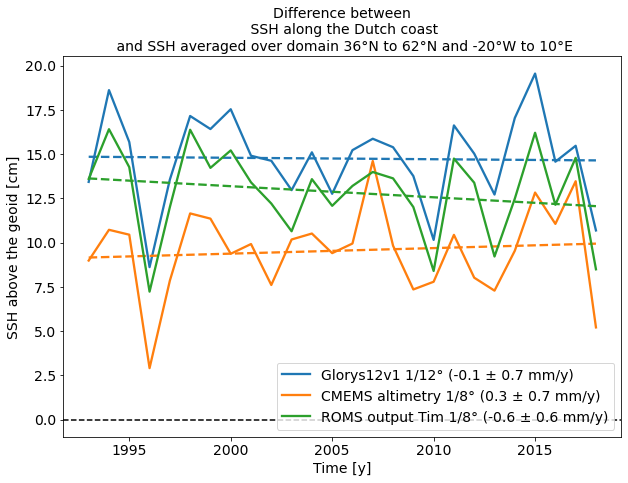

In [120]:
figure_ssh_difference([glorys12v1_difference*f_cm, cmems_altimetry_difference*f_cm, roms_output_tim_difference*f_cm],
           [glorys12v1.year, cmems_altimetry.where(cmems_altimetry.year <= 2018, drop = True).year, roms_output_tim.year],
          ['Glorys12v1 1/12°', 'CMEMS altimetry 1/8°', 'ROMS output Tim 1/8°'],
           'Difference between\n SSH along the Dutch coast\n and SSH averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_difference_ssh_glorys12_timoutput8')

#### Differences for anomalies

In [121]:
# Obtain differences by substracting the sea level along the Dutch coast from the domain mean 

glorys_difference_anom = (glorys12v1_stations['Average'] - glorys12v1_stations['Average'].mean()) - (glorys12v1_stations['Average'] - glorys12v1_stations['Average'].mean())
roms_tim_difference_anom =  (roms_output_tim_stations['Average'] - roms_output_tim_stations['Average'].mean()) - (roms_output_tim.slh.mean('lat').mean('lon') - roms_output_tim.slh.mean('lat').mean('lon').mean('year'))
cmems_difference_anom = (cmems_altimetry_stations[:-2]['Average'] - cmems_altimetry_stations[:-2]['Average'].mean()) - (cmems_altimetry.where(cmems_altimetry.year <= 2018, drop = True).adt.mean('longitude').mean('latitude') - cmems_altimetry.where(cmems_altimetry.year <= 2018, drop = True).adt.mean('longitude').mean('latitude').mean('year'))

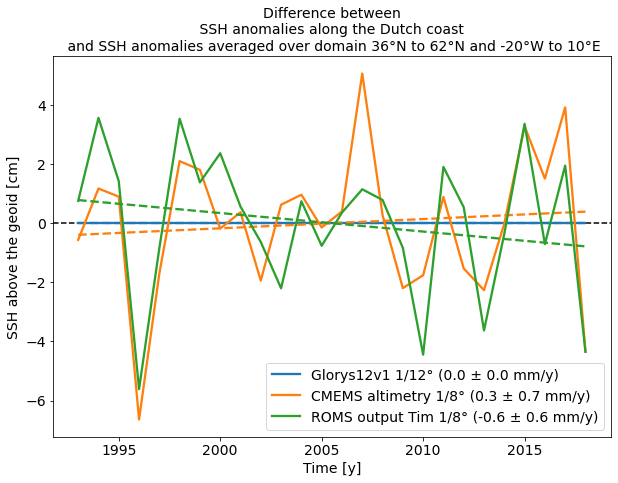

In [122]:
figure_ssh_difference([glorys_difference_anom*f_cm, cmems_difference_anom*f_cm, roms_tim_difference_anom*f_cm],
           [glorys12v1.year, cmems_altimetry.where(cmems_altimetry.year <= 2018, drop = True).year, roms_output_tim.year],
          ['Glorys12v1 1/12°', 'CMEMS altimetry 1/8°', 'ROMS output Tim 1/8°'],
           'Difference between\n SSH anomalies along the Dutch coast \n and SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_difference_ssh_anomalies_glorys12_timoutput8')

## Difference between ROMS averaged sea level and sea level along the Dutch coast

#### For Dewi's output and GLORYS2V3 data

In [123]:
# Obtain differences by substracting the sea level along the Dutch coast from the domain mean 

cmems_altimetry_difference = cmems_altimetry_stations[:-7]['Average'].values - cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).adt.mean('longitude').mean('latitude').values
roms_output_dewi4_exp29_difference = roms_output_dewi4_exp29_stations['Average'].values - roms_output_dewi4_exp29.slh.mean('lat').mean('lon').values
roms_output_dewi4_exp36_difference = roms_output_dewi4_exp36_stations['Average'].values - roms_output_dewi4_exp36.slh.mean('lat').mean('lon').values
roms_output_dewi8_difference = roms_output_dewi8_stations['Average'].values - roms_output_dewi8.slh.mean('lat').mean('lon').values
glorys2v3_difference = glorys2v3_stations['Average'].values - Glorys2v3.slh.mean('x').mean('y').values


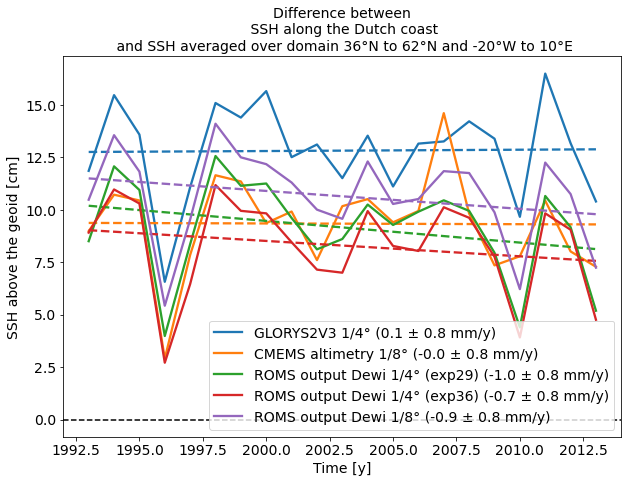

In [124]:
figure_ssh_difference([glorys2v3_difference*f_cm, cmems_altimetry_difference*f_cm, roms_output_dewi4_exp29_difference*f_cm, roms_output_dewi4_exp36_difference*f_cm, roms_output_dewi8_difference*f_cm],
           [Glorys2v3.year, cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).year, roms_output_dewi4_exp29.year, roms_output_dewi4_exp36.year, roms_output_dewi8.year],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/4° (exp29)', 'ROMS output Dewi 1/4° (exp36)', 'ROMS output Dewi 1/8°'],
           'Difference between\n SSH along the Dutch coast\n and SSH averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_difference_ssh_glorys2v3_dewioutput')

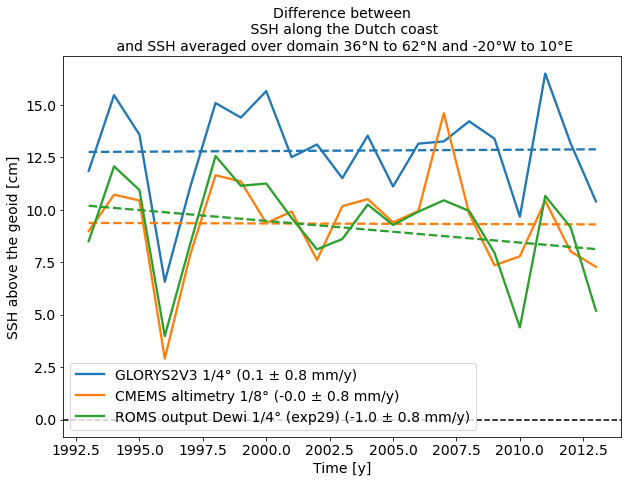

In [125]:
figure_ssh_difference([glorys2v3_difference*f_cm, cmems_altimetry_difference*f_cm, roms_output_dewi4_exp29_difference*f_cm],
           [Glorys2v3.year, cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).year, roms_output_dewi4_exp29.year],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/4° (exp29)'],
           'Difference between\n SSH along the Dutch coast\n and SSH averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_difference_ssh_glorys2v3_dewioutput_4_29')

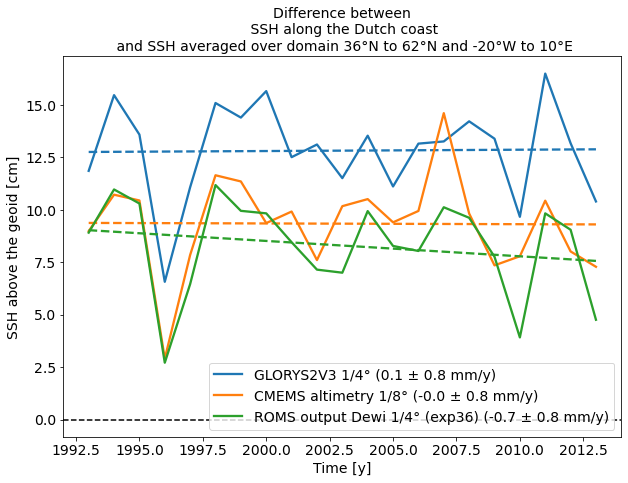

In [126]:
figure_ssh_difference([glorys2v3_difference*f_cm, cmems_altimetry_difference*f_cm, roms_output_dewi4_exp36_difference*f_cm],
           [Glorys2v3.year, cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).year, roms_output_dewi4_exp36.year],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/4° (exp36)'],
           'Difference between\n SSH along the Dutch coast\n and SSH averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_difference_ssh_glorys2v3_dewioutput_4_36')

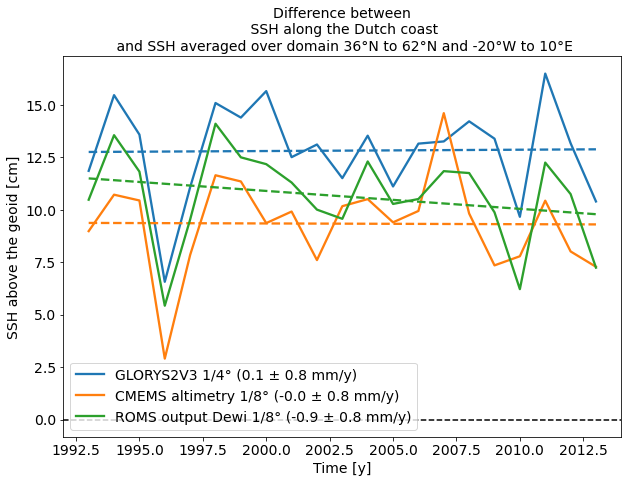

In [127]:
figure_ssh_difference([glorys2v3_difference*f_cm, cmems_altimetry_difference*f_cm, roms_output_dewi8_difference*f_cm],
           [Glorys2v3.year, cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).year, roms_output_dewi8.year],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/8°'],
           'Difference between\n SSH along the Dutch coast\n and SSH averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_difference_ssh_glorys2v3_dewioutput_8')

#### Differences for anomalies

In [128]:
# Obtain differences by substracting the sea level along the Dutch coast from the domain mean 

cmems_difference_anom2 = (cmems_altimetry_stations[:-7]['Average'] - cmems_altimetry_stations[:-7]['Average'].mean()) - (cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).adt.mean('longitude').mean('latitude') - cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).adt.mean('longitude').mean('latitude').mean('year'))
roms_output_dewi4_exp29_difference_anom = (roms_output_dewi4_exp29_stations['Average'] - roms_output_dewi4_exp29_stations['Average'].mean()) - (roms_output_dewi4_exp29.slh.mean('lat').mean('lon') - roms_output_dewi4_exp29.slh.mean('lat').mean('lon').mean('year'))
roms_output_dewi4_exp36_difference_anom = (roms_output_dewi4_exp36_stations['Average'] - roms_output_dewi4_exp36_stations['Average'].mean()) - (roms_output_dewi4_exp36.slh.mean('lat').mean('lon') - roms_output_dewi4_exp36.slh.mean('lat').mean('lon').mean('year'))
roms_output_dewi8_difference_anom = (roms_output_dewi8_stations['Average'] - roms_output_dewi8_stations['Average'].mean()) - (roms_output_dewi8.slh.mean('lat').mean('lon') - roms_output_dewi8.slh.mean('lat').mean('lon').mean('year'))
glorys2v3_difference_anom = (glorys2v3_stations['Average'] - glorys2v3_stations['Average'].mean()) - (Glorys2v3.slh.mean('x').mean('y') - Glorys2v3.slh.mean('x').mean('y').mean('year'))



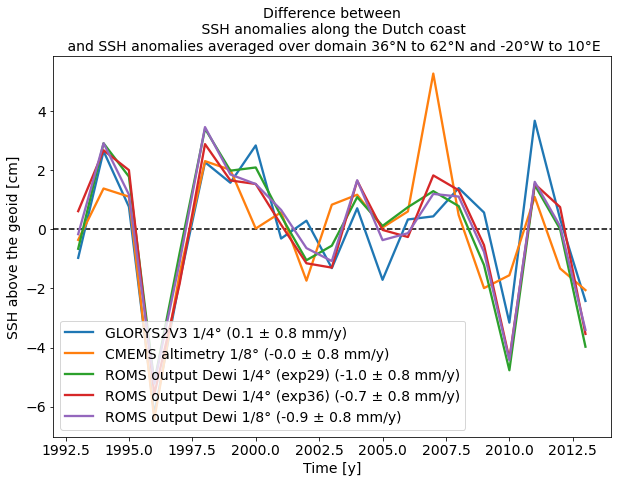

In [129]:
figure_ssh_difference([glorys2v3_difference_anom*f_cm, cmems_difference_anom2*f_cm, roms_output_dewi4_exp29_difference_anom*f_cm, roms_output_dewi4_exp36_difference_anom*f_cm, roms_output_dewi8_difference_anom*f_cm],
           [Glorys2v3.year, cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).year, roms_output_dewi4_exp29.year, roms_output_dewi4_exp36.year, roms_output_dewi8.year],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/4° (exp29)', 'ROMS output Dewi 1/4° (exp36)', 'ROMS output Dewi 1/8°'],
           'Difference between\n SSH anomalies along the Dutch coast\n and SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_difference_ssh_anomalies_glorys2v3_dewioutput', trends = False)

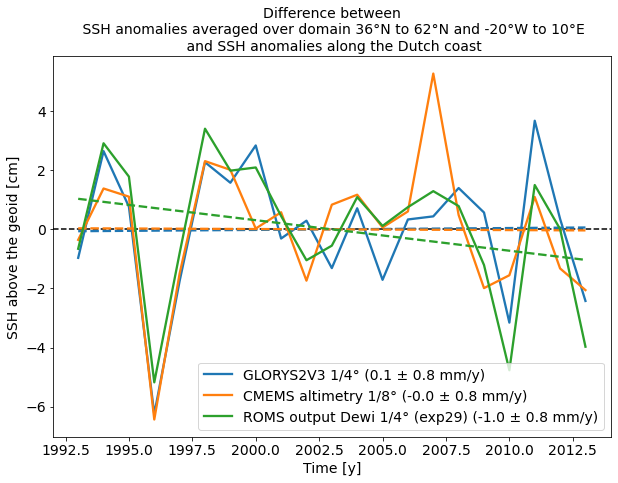

In [130]:
figure_ssh_difference([glorys2v3_difference_anom*f_cm, cmems_difference_anom2*f_cm, roms_output_dewi4_exp29_difference_anom*f_cm],
           [Glorys2v3.year, cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).year, roms_output_dewi4_exp29.year],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/4° (exp29)'],
           'Difference between\n SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E\n and SSH anomalies along the Dutch coast',
          'roms_difference_ssh_anomalies_glorys2v3_dewioutput_4_29')

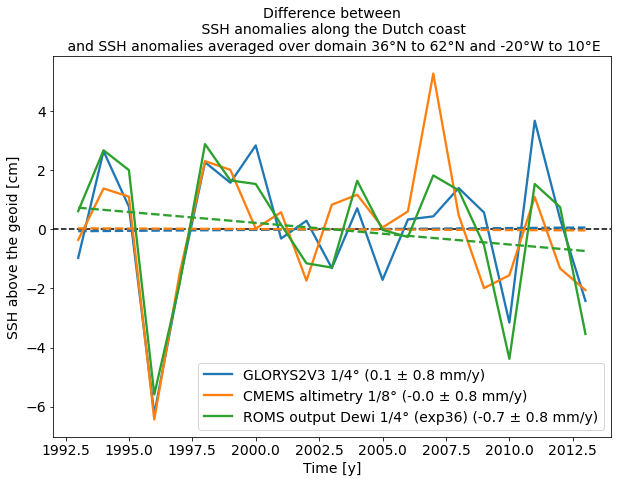

In [131]:
figure_ssh_difference([glorys2v3_difference_anom*f_cm, cmems_difference_anom2*f_cm, roms_output_dewi4_exp36_difference_anom*f_cm],
           [Glorys2v3.year, cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).year, roms_output_dewi4_exp29.year, roms_output_dewi4_exp36.year, roms_output_dewi8.year],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/4° (exp36)'],
           'Difference between\n SSH anomalies along the Dutch coast\n and SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_difference_ssh_anomalies_glorys2v3_dewioutput_4_36')

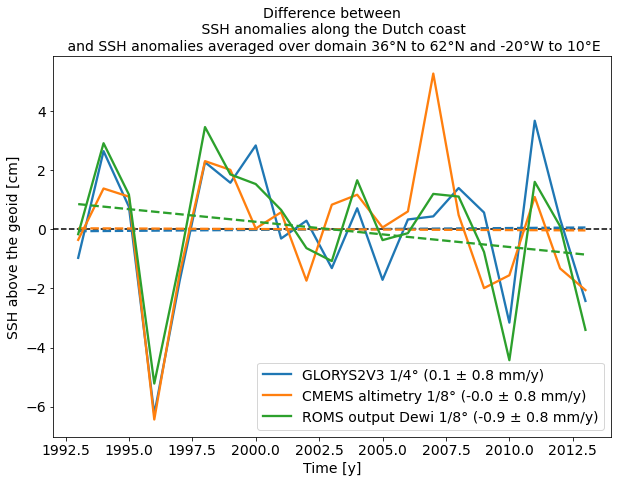

In [132]:
figure_ssh_difference([glorys2v3_difference_anom*f_cm, cmems_difference_anom2*f_cm, roms_output_dewi8_difference_anom*f_cm],
           [Glorys2v3.year, cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).year, roms_output_dewi8.year],
          ['GLORYS2V3 1/4°', 'CMEMS altimetry 1/8°', 'ROMS output Dewi 1/8°'],
           'Difference between\n SSH anomalies along the Dutch coast\n and SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_difference_ssh_anomalies_glorys2v3_dewioutput_8')